In [1]:
from yroots.utils import condeigs
from yroots.polyroots import solve
from yroots.Multiplication import *
import yroots as yr
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from tests.devastating_example_test_scripts import *
from tests.growth_factors import *
from scipy.stats import linregress
from scipy.spatial.distance import pdist
%load_ext autoreload
%autoreload 2

Recall that the condition number of a simple root $z$ of $f:\mathbb{R}^n\mapsto\mathbb{R}^n$ is:
    $$\kappa(z,f) = \left\lVert{Df(z)^{-1}}\right\rVert_2$$
and that the condition number of a simple eigenvalue $\lambda$ of A such that $Ax = \lambda x$ and $A^*y = \lambda y$ is:
    $$\kappa(\lambda,A) = \frac{\left\lVert{x}\right\rVert \left\lVert{y}\right\rVert}{|y^*x|}$$
    
Define the \textit{growth factor} for a M\"oller-Stetter eigenproblem for an eigenvalue $\lambda$ corresponding to a root $z$ to be:
    $$GF(\lambda,z,f,m_h) = \log_{10}\frac{\kappa(\lambda,m_h)}{\kappa(z,f)}$$
    
This measures how many additional digits of precision may be lost when converting the root-finding problem into an eigenproblem.

<img src="growthfactor.png" width=600 height=600 />


# loading in data saved from the server

### random systems

In [2]:
folder = 'tests/growth_factors/rand/newton/'
normal_masks = {d:~np.load(folder+f'dim{d}/not_full_roots_deg2.npy')\
                for d in range(3,7)}
normal_masks[7] = np.ones(200,dtype=bool)
normal_masks[2] = np.ones(300,dtype=bool)
rand_polished = {d:np.stack(np.load(folder+f'dim{d}/deg2_res.npy',
                                allow_pickle=True)[normal_masks[d]])
                      for d in range(2,8)}
rand_polished[8] = np.stack([np.load(folder+f'dim8/deg2_sys{i}.npy')
                                 for i in range(23)])
for d in rand_polished.keys():
    print(rand_polished[d].shape)

(300, 2, 4)
(295, 3, 8)
(298, 4, 16)
(298, 5, 32)
(198, 6, 64)
(200, 7, 128)
(23, 8, 256)


### devestating systems

In [3]:
folder = 'tests/growth_factors/dev/newton/'
dev_polished = {d:np.stack(np.load(folder+f'dim{d}/deg2.npy',
                                allow_pickle=True))
                      for d in range(2,7)}
dev_polished[7] = [np.load(folder+f'dim7/deg2_sys{i}.npy',
                                    allow_pickle=True)
                                 for i in range(45)]
dev_polished[8] = [np.load(folder+f'dim8/deg2_sys{i}.npy',
                                    allow_pickle=True)
                                 for i in range(25)]
#I accidentally saved the converging root info-- so let's check that out now and then remove it
for d in dev_polished.keys():
    for i,sys in enumerate(dev_polished[d]):
        if d > 6:
            sys = sys[0]
        gf,newt_dist,root_dist = sys
        if not 10*newt_dist < root_dist:
            print(d,i)
            print('**Potentially converging roots with polishing**')
            print(f'\tNewton changed roots by at most: {newt_dist}')
            print(f'\tDist between root was at least:  {root_dist}')
    dev_polished[d] = np.array([sys[0] for sys in dev_polished[d]])
for d in [7,8]:
    dev_polished[d] = np.array([sys[0] for sys in dev_polished[d]])
for d in dev_polished.keys():
    print(dev_polished[d].shape)  

(50, 2)
(50, 3)
(50, 4)
(50, 5)
(50, 6)
(45, 7)
(25, 8)


### comparison to without polishing

ls tests/growth_factors/rand/nopol/dim3

folder = 'tests/growth_factors/rand/nopol/'
normal_masks_nopol = {d:~np.load(folder+f'dim{d}/not_full_roots_deg2.npy') for d in range(3,5)}
normal_masks_nopol[2] = np.ones(300,dtype=bool)
rand_nopol = {d:np.stack(np.load(folder+f'dim{d}/deg2_res.npy',
                                allow_pickle=True)[normal_masks_nopol[d]])
                      for d in range(2,5)}
for d in rand_nopol.keys():
    print(rand_nopol[d].shape)

folder = 'tests/growth_factors/dev/nopol/'
dev_nopol = {d:np.stack(np.load(folder+f'dim{d}/deg2.npy',
                                allow_pickle=True))
                      for d in range(2,5)}
for d in dev_nopol.keys():
    print(dev_nopol[d].shape)  

# devestating example
run the same code on devastating examples with eps = .1 to show empirical line, with a perturbed coefficient tensor too to show it gets nice if you do that

why are other things ill conditioned sometimes?

gf_dev_1 = devestating_growth_factors([2,3,4,5],.1,'power')
shifted_gf_dev_1 = devestating_growth_factors([2,3,4,5],.1,'spower')

gf_dev_1_pert = devestating_growth_factors([2,3,4,5],.1,'power',perturb_eps=.001)

gf_dev_1_pert2 = devestating_growth_factors([2,3,4,5],.1,'power',perturb_eps=.001)

gf_dev_2 = devestating_growth_factors([2,3,4,5],.01,'power')
shifted_gf_dev_2 = devestating_growth_factors([2,3,4,5],.01,'spower')

gf_dev_3 = devestating_growth_factors([2,3,4,5],.001,'power')

# data info

In [4]:
def get_log_medians(data):
    return [np.median(np.log10(data[d])) for d in data.keys()]
def get_perc_neg(data):
    return [np.mean(np.log10(data[d])<0)*100 for d in data.keys()]

# plotting

plot([gf_dev_1,shifted_gf_dev_1,gf_dev_2,shifted_gf_dev_2],
     [r'Devestating Systems, $\epsilon=.1$',r'Shifted Devestating Systems, $\epsilon=.1$',
      r'Devestating Systems, $\epsilon=.01$',r'Shifted Devestating Systems, $\epsilon=.01$'],
     figsize=(15,10))

0.042297149196839905 0.24599742391990143
1.0000433894444425 -0.9981340387625659


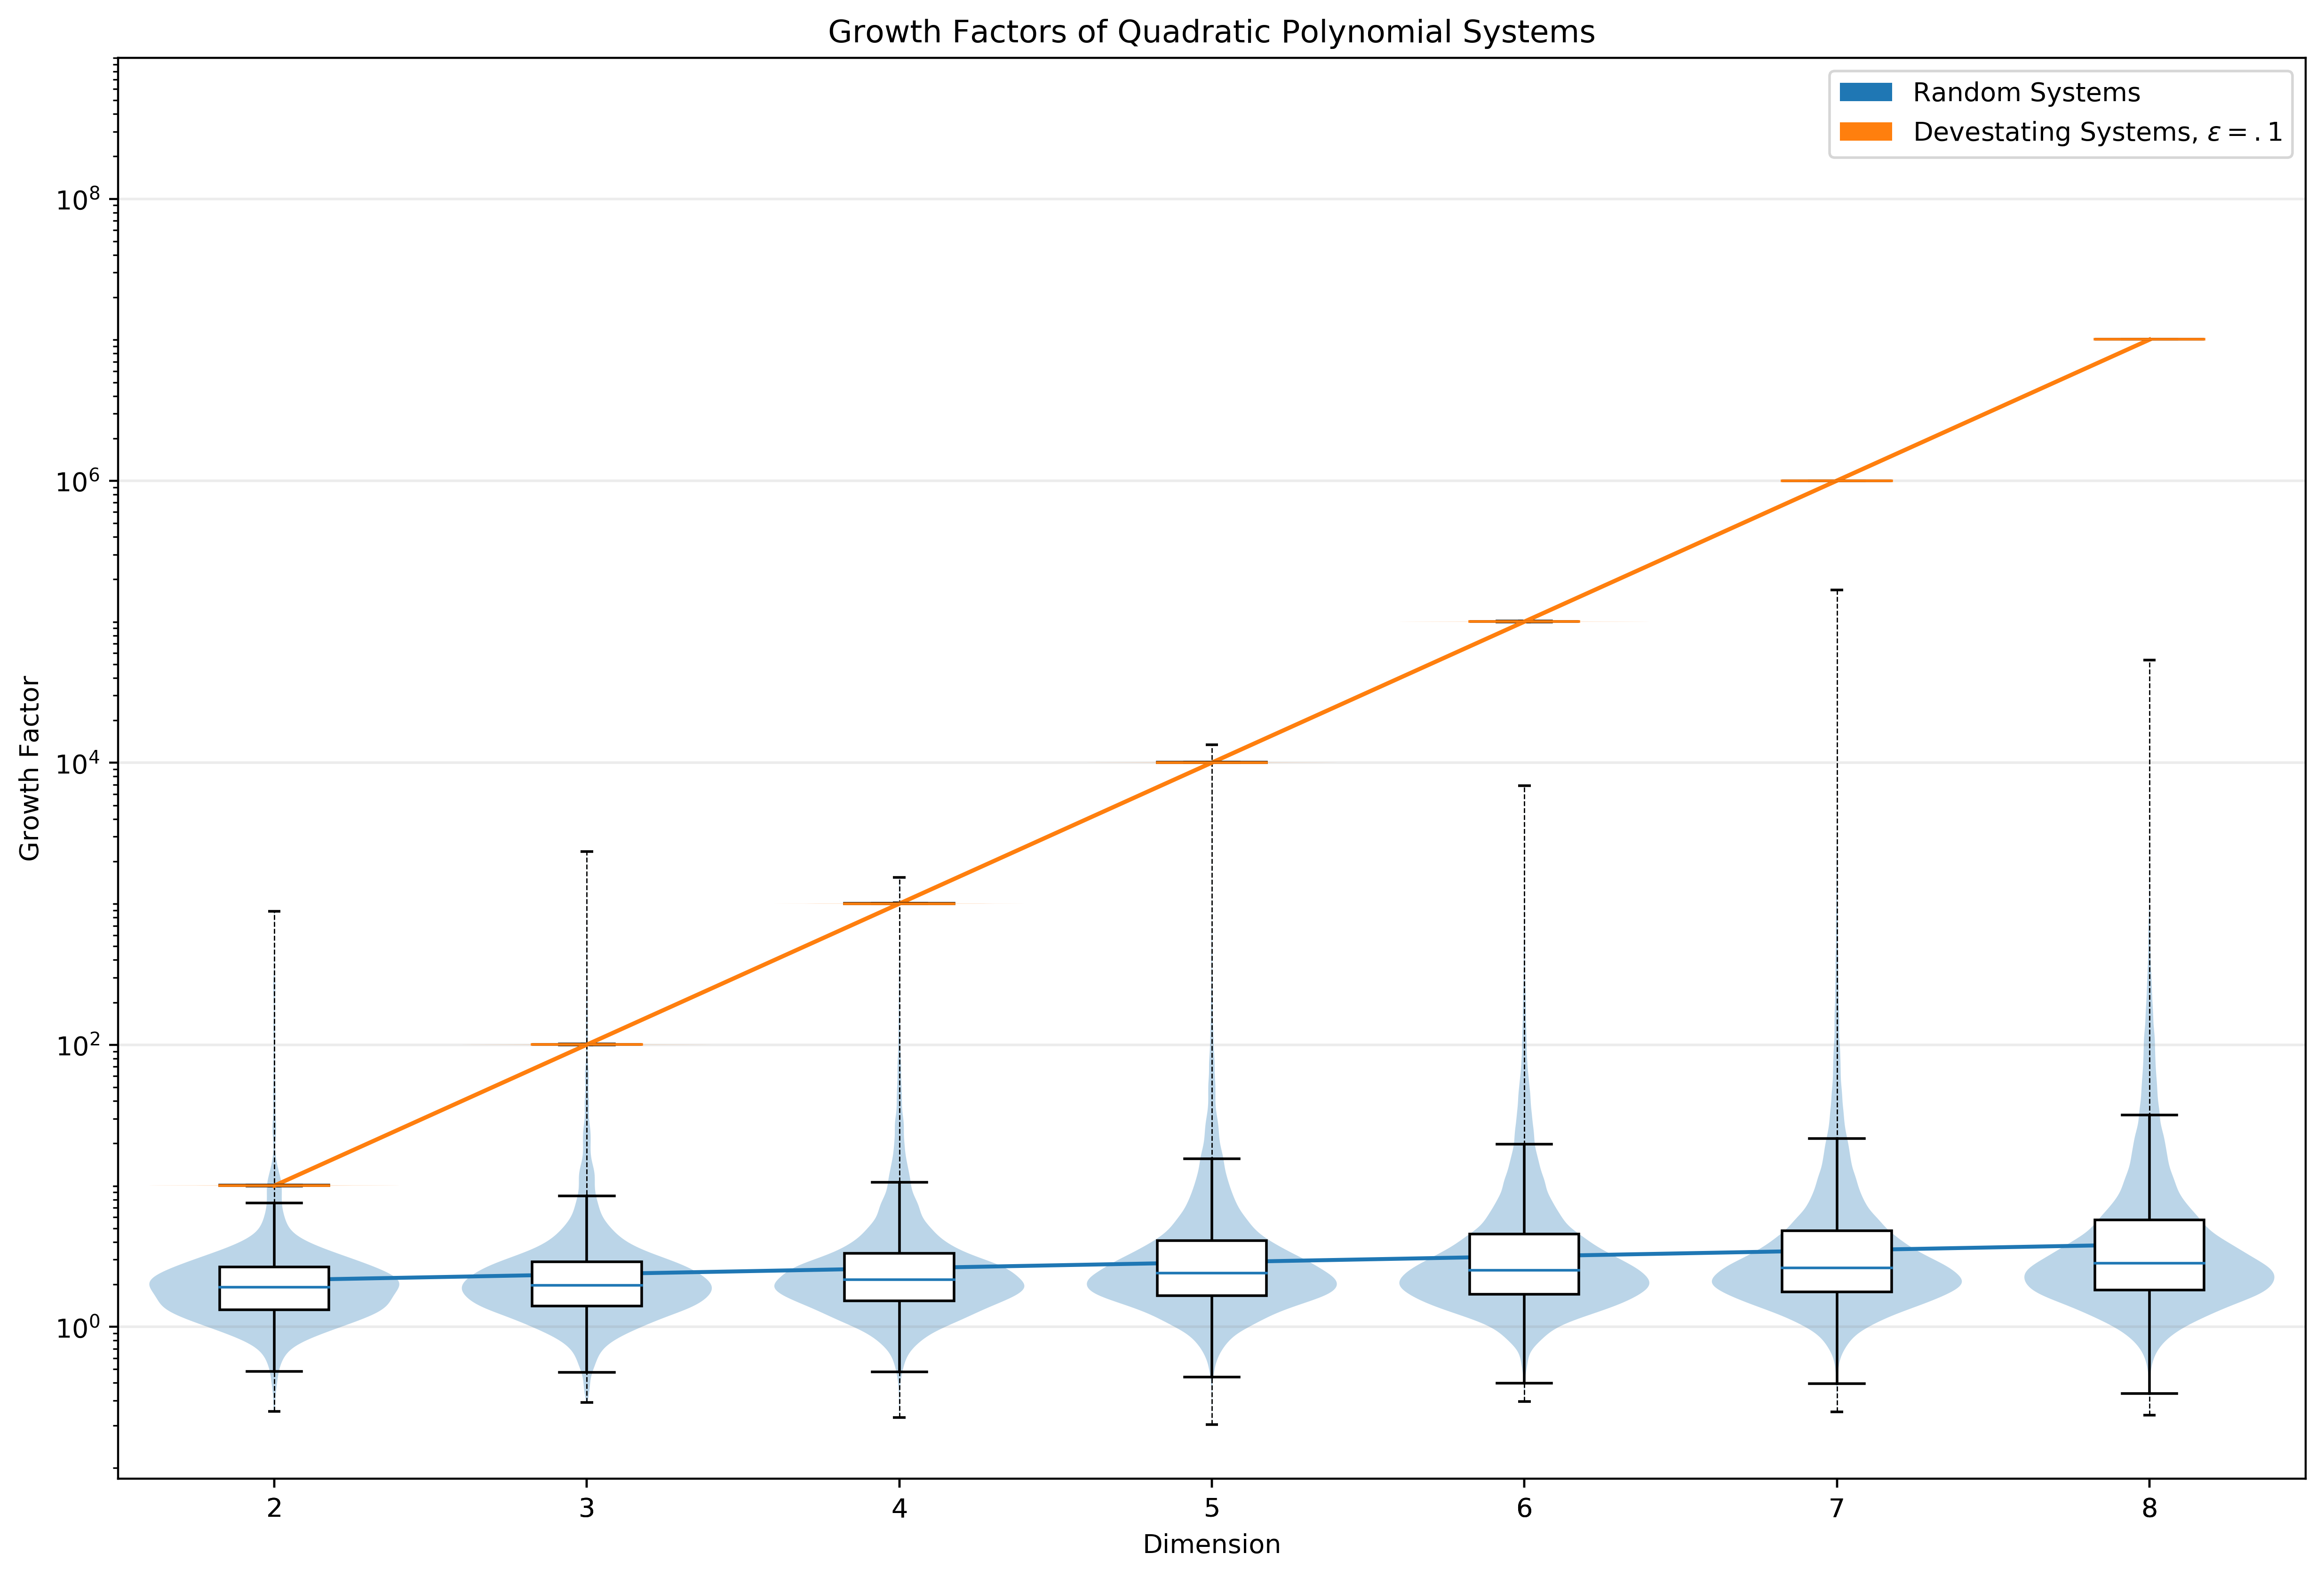

In [6]:
plot([rand_polished,dev_polished],
     ['Random Systems',r'Devestating Systems, $\epsilon=.1$'],
     figsize=(15,10))

* figsize is the desired actual size in the final printed article, measured in inches -- controlable
* dpi at least 300 -- defaults to 400
* file type  pdf -- does that in saving
* bbox_inches = ‘tight’ -- does that in saving

In [8]:
print('log medians')
print('Rand:',np.round(get_log_medians(rand_polished),4))
print('Dev :',np.round(get_log_medians(dev_polished),4))
print('Rand % Negative:',np.round(get_perc_neg(rand_polished),4))

log medians
Rand: [0.2801 0.2958 0.3331 0.3817 0.4027 0.4176 0.452 ]
Dev : [1.0028 2.0018 3.0015 4.0021 5.0019 6.0012 7.0034]
Rand % Negative: [9.5833 9.096  6.9107 5.0902 4.2508 3.7985 3.8086]


# weird errors: svd on dim 7

polys = devestating_growth_factors([7],.1,'power',newton=True,N=50,just_dev_root=True,seed=468,perturb_eps=0,save=False)

polys

M,terms,cut = yr.polysolve(polys)

M.shape

reduce_macaulay_svd(M,cut)

# why??? why you no have 8 roots?

it was basically because the numerical rank was sometimes incorrect, i.e. didn't match the bezout bound

In [ ]:
weird_masks = {d:~normal_masks[d] for d in normal_masks.keys()}

In [ ]:
where_weird = {d:np.where(weird_masks[d])[0] for d in weird_masks.keys()}

In [ ]:
where_weird

# I've noticed it's not consistent between the server and my computer which ones it doesn't get enough roots on. Like some always fail, and some only fail sometimes

e.g. 10 is showing up as weird here, but not when i run it on my computer

In [ ]:
def plot_scree(s,tol,dim,sys_num):
    plt.semilogy(s,marker='.')
    plt.plot(np.ones(len(s))*tol)
    plt.show()

In [ ]:
coeffs3d = np.load('tests/random_tests/coeffs/dim3_deg2_randn.npy')

In [ ]:
coeffs4d = np.load('tests/random_tests/coeffs/dim4_deg2_randn.npy')

In [ ]:
def plot_sys(dim,sys_num):
    print('System Number',sys_num)
    if   dim == 4: polys = [yr.MultiPower(c) for c in coeffs4d[sys_num]]
    elif dim == 3: polys = [yr.MultiPower(c) for c in coeffs3d[sys_num]]
    roots,M = yr.polysolve(polys)
    print('\nRoots shape:',roots.shape)
    print('\nlog|Residuals|')
    for p in polys:
        print(np.round(np.log10(np.abs(p(roots))),2))

In [ ]:
for sys in where_weird[3]:
    plot_sys(3,sys)
    plt.show()
    plt.tight_layout()